# ***Spark vs Pandas vs Polars: time analysis***

## **Introduction**

In this project we have carried out three studies on the data provided in a CSV file with information about taxi trips in New York. We have had to clean the dataset first to remove the records with wrong data and remove outliers. To carry out the studies, as it was required, we have used the entire Spark's API, including the manipulation of RDDs, dataframes and direct SQL.
We have also analyzed both execution time and speedup in each study, for doing this we have measure time of the actions in each process, excluding the previous transformations as they are included in the action.

The three studies are the following:
1. ***Average speed of taxis in terms of the hour:*** we have done five versions of this study with Spark df,  Spark rdd, Spark SQL, Pandas and Polars.
2. ***Most common taxi trips:*** Spark df.
3. ***Average of tips for each zone:*** Spark SQL.

## **Requirements**  

In [1]:
# pip install findspark

We start the Spark Session with all the cores of our computer and divide the tasks with coalesce(32). However, we have perform different tests on the processes using different number of cores.

In [9]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Intro to Spark').master("local[*]").getOrCreate()
sc = spark.sparkContext

#############################################

import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
from pyspark.sql.functions import round, expr, from_unixtime, unix_timestamp, date_format, count, concat, lit, col
from pyspark.sql.types import IntegerType

Next, we read the dataset provided.

In [3]:
taxis_df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(r"./Data/taxis.csv")
taxis_df = taxis_df.coalesce(32)
taxis_df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|        15.3|
|       1| 2017-01-09 11:32:27|  2017-01-09 11:3

In [4]:
taxis_df.describe().show()

+-------+-------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+-------------------+------------------+-------------------+---------------------+------------------+
|summary|           VendorID|   passenger_count|     trip_distance|         RatecodeID|store_and_fwd_flag|      PULocationID|     DOLocationID|      payment_type|      fare_amount|              extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|
+-------+-------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+-------------------+------------------+-------------------+---------------------+------------------+
|  count|             971010|            971010|            971010|             971010|          

## **Data cleaning with `Spark` data-frames**

Now, we are going to clean the dataset removing the records with wrong data to prevent errors in the calculations and removing outliers to prevent errors in the analysis of the data.

In [5]:
start_time = time.time()

- Removing trips (rows) with zero (0) duration:

We calculate the duration of the trips in order to remove those which duration is 0. To calculate the trip duration we have made the difference between the dropoff datetime and the pickup datetime. As it is given in seconds we have divided by 3600 to obtain the hours.

In [6]:
taxis_df = taxis_df.withColumn("trip_duration_hours", round(expr("(unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)) / 3600"), 3))
taxis_df = taxis_df.filter(taxis_df['trip_duration_hours'] > 0)

In [7]:
taxis_df.count()

970052

- Removing rows with `total_amount`, `tip_amount`, `mta_tax`, `fare_amount` <= 0.

In [8]:
for col in ['total_amount', 'fare_amount'] :

    taxis_df = taxis_df.filter(taxis_df[col] > 0)

In [9]:
for col in ['tip_amount', 'mta_tax'] :

    taxis_df = taxis_df.filter(taxis_df[col] >= 0)

In [10]:
taxis_df.count()

969319

- Removing upper outliers in `total_amount`, `tolls_amount`. 

In [11]:
for col in ['total_amount', 'tolls_amount'] :

    quantiles = taxis_df.select(col).summary("25%", "75%").collect()
    Q25 = float(quantiles[0][col])
    Q75 = float(quantiles[1][col])
    IQR = Q75 - Q25
    upper_bound = Q75 + 2.5*IQR
    taxis_df = taxis_df.filter(taxis_df[col] <= upper_bound)

In [12]:
end_time = time.time()
data_cleaning_spark_df_time = end_time - start_time

In [13]:
print('Time of data cleaning with Spark data-frames: ', data_cleaning_spark_df_time)

Time of data cleaning with Spark data-frames:  6.593500852584839


In [14]:
taxis_df.count()

900387

## **Data-set conceptual description** <a class="anchor" id="7"></a>

The following table contain a brief conceptual description about the precious data-set, as well as the variable type.

|      Variable           |          Description  |  Type  |
|:------------------------:|:---------------------:|:---------------------:|
| VendorID   | A code indicating the TPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.  | ID  |
| tpep_pickup_datetime | The date and time when the meter was engaged.  | Date |
| tpep_dropoff_datetime    | The date and time when the meter was disengaged.   | Date |
|  Passenger_count | The number of passengers in the vehicle.  | Quantitative |
|  Trip_distance   | The elapsed trip distance in miles reported by the taximeter.  | Quantitative |
| PULocationID  |  TLC Taxi Zone in which the taximeter was engaged | ID |
|  DOLocationID   |  TLC Taxi Zone in which the taximeter was disengaged   | ID |
|  RateCodeID | The final rate code in effect at the end of the trip. 1= Standard rate. 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride | Categorical |
|  Store_and_fwd_flag   |  This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,”because the vehicle did not have a connection to the server. Y= store and forward trip, N= not a store and forward trip  | Categorical |
|  Payment_type   |  A numeric code signifying how the passenger paid for the trip. 1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip   | Categorical |
|  Fare_amount   |  The time-and-distance fare calculated by the meter.   | Quantitative |
|  Extra   |  Miscellaneous extras and surcharges.  Currently, this only includes the $0.50 and $1 rush hour and overnight charges.   | Quantitative |
|  MTA_tax   |  $0.50 MTA tax that is automatically triggered based on the metered rate in use.    | Quantitative |
|  Improvement_surcharge    |  $0.30 improvement surcharge assessed trips at the flag drop. The improvement urcharge began being levied in 2015.    | Quantitative |
|  Tip_amount   |  Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.   | Quantitative |
| Tolls_amount  |  Total amount of all tolls paid in trip.   | Quantitative |
|  Total_amount   |  The total amount charged to passengers. Does not include cash tips.   | Quantitative |
|  Total_amount   |  The total amount charged to passengers. Does not include cash tips.   | Quantitative |
|  Congestion_Surcharge   |  Total amount collected in trip for NYS congestion surcharge.  | Quantitative |
|  Airport_fee    |  The total amount charged to passengers. Does not include cash tips.   | Quantitative |


## **Study 1: Average speed of taxis in terms of the hour**

In this study we are going to calculate the average speed of NY taxis each hour of the day to be able to analyze the traffic in the city. We have done this study with data-frames, RDD, SQL and also with Pandas.
We have carried out the following steps:
1. Converte trip distance from miles to kilometers.
2. Calculate speed by dividing trip distance over trip duration calculated before.
3. We group by the hour of the day calculating the mean of the speed.
4. We plot the results.

#### **With Spark data-frames**

In [15]:
taxis_df_copy = taxis_df.alias('taxis_df_copy')
taxis_df_copy.show(2)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|trip_duration_hours|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|  

In [16]:

taxis_df_copy = taxis_df_copy.withColumn("trip_distance_km", round(taxis_df_copy["trip_distance"]*1.609344, 3))
taxis_df_copy = taxis_df_copy.withColumn("trip_speed_km_h",  round(taxis_df_copy['trip_distance_km'] / taxis_df_copy['trip_duration_hours'], 3))
taxis_df_copy = taxis_df_copy.withColumn("hour_time", date_format(from_unixtime(unix_timestamp("tpep_pickup_datetime", "yyyy-MM-dd HH:mm:ss")), "HH"))
hours_speed_df = taxis_df_copy.groupBy("hour_time").mean('trip_speed_km_h')
hours_speed_df = hours_speed_df.withColumn("hour_time", hours_speed_df["hour_time"].cast(IntegerType())) # Convert the "hour_time" column to integer type
start_time = time.time()
hours_speed_df_pd = hours_speed_df.toPandas()
end_time = time.time()
task1_spark_df_time = end_time - start_time
print('Time of task 1 with Spark data-frames', task1_spark_df_time)

Time of task 1 with Spark data-frames 2.0894644260406494


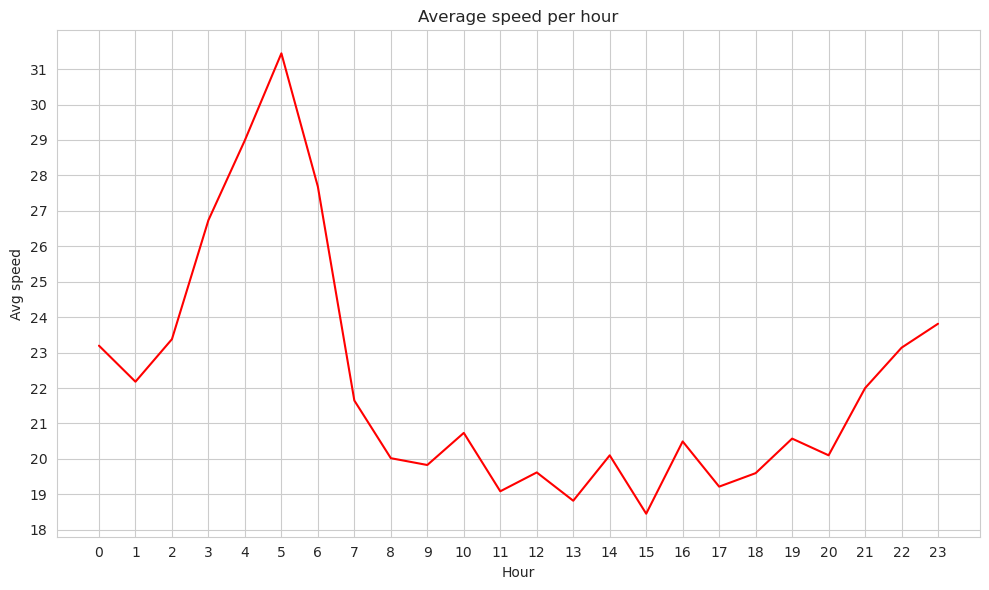

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="hour_time", y="avg(trip_speed_km_h)", data=hours_speed_df_pd, color='red')
plt.xlabel("Hour")
plt.ylabel("Avg speed")
plt.title("Average speed per hour")
plt.xticks(range(0,24), rotation=0) 
min = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].min())
max = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].max())
ysticks_ = np.unique(np.round(np.linspace(min, max, 15)))
plt.yticks(ysticks_) 
plt.tight_layout()
plt.show()

#### **With Spark RDD**

In [18]:
taxis_df_copy = taxis_df.alias('taxis_df_copy')
taxis_df_copy.show(2)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|trip_duration_hours|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|  

In [19]:
def calculate_elapsed_hours(start_time, end_time):
    elapsed_time = (end_time - start_time).total_seconds() / 3600
    return np.round(elapsed_time,3)

In [20]:
trip_distance_rdd = taxis_df_copy.select('trip_distance').rdd.map(lambda x: x[0])
trip_distance_km_rdd = trip_distance_rdd.map(lambda x : np.round(x*1.609344, 3))
tpep_dropoff_datetime_rdd = taxis_df_copy.select('tpep_dropoff_datetime').rdd.map(lambda x: x[0])
tpep_pickup_datetime_rdd = taxis_df_copy.select('tpep_pickup_datetime').rdd.map(lambda x: x[0])
datetime_rdd = taxis_df_copy.select('tpep_pickup_datetime', 'tpep_dropoff_datetime').rdd.map(lambda x: (x[0],x[1]))
trip_duration_rdd = datetime_rdd.map(lambda x : calculate_elapsed_hours(x[0], x[1]))
trip_distance_time_rdd = trip_distance_km_rdd.zip(trip_duration_rdd)
trip_speed_rdd = trip_distance_time_rdd.map(lambda x : np.round(x[0] / x[1], 3))
trip_hour_rdd = tpep_pickup_datetime_rdd.map(lambda x : x.hour)
key_hour_rdd = trip_hour_rdd.map(lambda x : (x,1))
trip_hour_sum_hour_rdd = key_hour_rdd.reduceByKey(lambda x,y : x + y)
trip_hour_speed_rdd = trip_hour_rdd.zip(trip_speed_rdd)
trip_hour_sum_speed_rdd = trip_hour_speed_rdd.reduceByKey(lambda x,y : np.round(x + y, 3)) 
avg_speed_hour_rdd = trip_hour_sum_hour_rdd.zip(trip_hour_sum_speed_rdd).map(lambda x : (np.round(x[1][1] / x[0][1], 3))) 
hours_new_order_rdd = trip_hour_sum_hour_rdd.map(lambda x : x[0])
start_time = time.time()
avg_speed_hour_list = avg_speed_hour_rdd.collect()
hours_new_order_list = hours_new_order_rdd.collect()
end_time = time.time()
task1_spark_rdd_time = end_time - start_time
print('Time of task 1 with Spark RDDs', task1_spark_rdd_time)

Time of task 1 with Spark RDDs 15.936208009719849


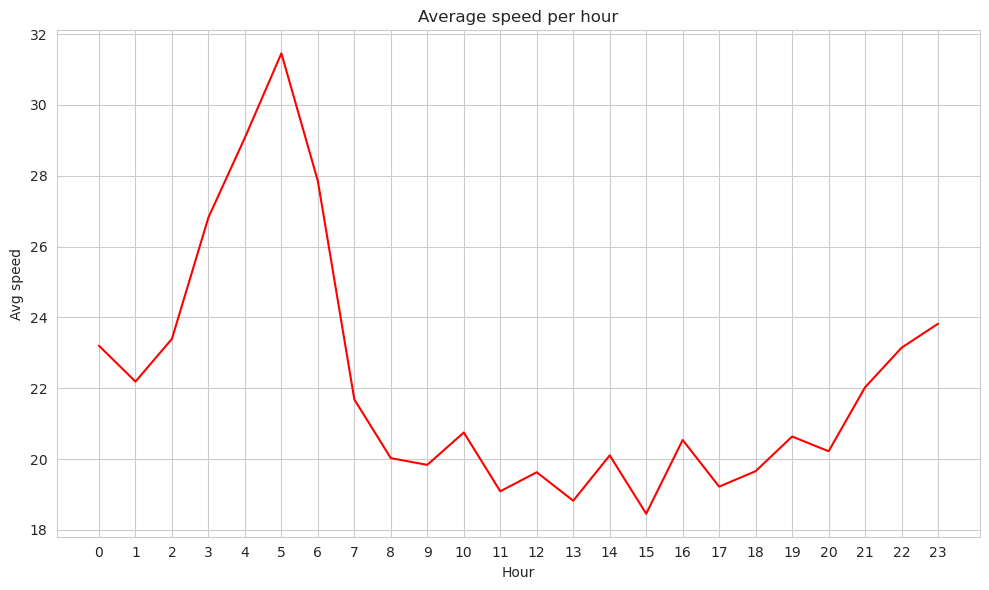

In [21]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=hours_new_order_list, y=avg_speed_hour_list, color='red')
plt.xlabel("Hour")
plt.ylabel("Avg speed")
plt.title("Average speed per hour")
plt.xticks(range(0,24), rotation=0) 
#min = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].min())
#max = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].max())
#ysticks_ = np.unique(np.round(np.linspace(min, max, 15)))
#plt.yticks(ysticks_) 
plt.tight_layout()
plt.show()

#### **With Spark SQL**


In [22]:
taxis_df_copy = taxis_df.alias('taxis_df_copy')
taxis_df_copy.show(2)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|trip_duration_hours|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|  

In [23]:
taxis_df_copy.createOrReplaceTempView('taxis_df_copy') 
taxis_df_copy = spark.sql("SELECT *, round(trip_distance*1.609344, 3) as trip_distance_km FROM taxis_df_copy")
taxis_df_copy.createOrReplaceTempView('taxis_df_copy') 
taxis_df_copy = spark.sql("SELECT *, round(trip_distance_km / trip_duration_hours, 3) as trip_speed_km_h FROM taxis_df_copy") 
taxis_df_copy.createOrReplaceTempView('taxis_df_copy') 
taxis_df_copy = spark.sql("SELECT *, hour(tpep_pickup_datetime) as hour_time FROM taxis_df_copy")
taxis_df_copy.createOrReplaceTempView('taxis_df_copy') 
hours_speed_df = spark.sql("SELECT CAST(hour_time AS INT) AS hour_time, avg(trip_speed_km_h) FROM taxis_df_copy GROUP BY hour_time") 
start_time = time.time()
hours_speed_df_pd = hours_speed_df.toPandas()
end_time = time.time()
task1_spark_sql_time = end_time - start_time
print('Time of task 1 with Spark SQL', task1_spark_sql_time)

Time of task 1 with Spark SQL 2.2889022827148438


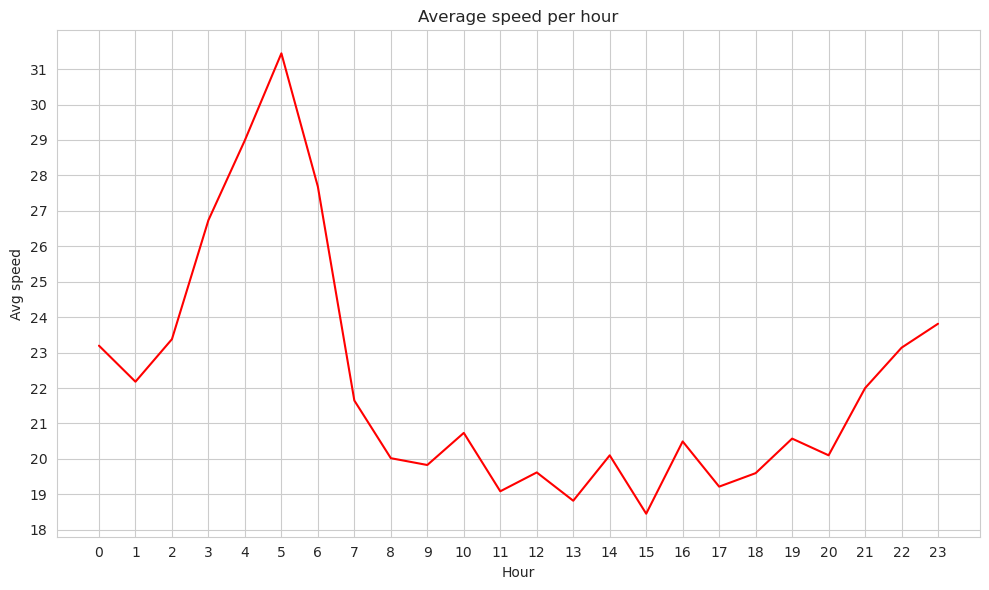

In [24]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="hour_time", y="avg(trip_speed_km_h)", data=hours_speed_df_pd, color='red')
plt.xlabel("Hour")
plt.ylabel("Avg speed")
plt.title("Average speed per hour")
plt.xticks(range(0,24), rotation=0) 
min = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].min())
max = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].max())
ysticks_ = np.unique(np.round(np.linspace(min, max, 15)))
plt.yticks(ysticks_) 
plt.tight_layout()
plt.show()

#### **With Pandas**


In [25]:
taxis_df_pd = pd.read_csv(r"./Data/taxis.csv")
taxis_df_pd.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2017-01-09 11:13:28,2017-01-09 11:25:45,1,3.30,1,N,263,161,1,12.5,0.0,0.5,2.00,0.0,0.3,15.30
1,1,2017-01-09 11:32:27,2017-01-09 11:36:01,1,0.90,1,N,186,234,1,5.0,0.0,0.5,1.45,0.0,0.3,7.25
2,1,2017-01-09 11:38:20,2017-01-09 11:42:05,1,1.10,1,N,164,161,1,5.5,0.0,0.5,1.00,0.0,0.3,7.30
3,1,2017-01-09 11:52:13,2017-01-09 11:57:36,1,1.10,1,N,236,75,1,6.0,0.0,0.5,1.70,0.0,0.3,8.50
4,2,2017-01-01 00:00:00,2017-01-01 00:00:00,1,0.02,2,N,249,234,2,52.0,0.0,0.5,0.00,0.0,0.3,52.80


In [26]:
taxis_df_pd.shape

(971010, 17)

##### **Data cleaning with Pandas**

In [27]:
start_time = time.time()

- Removing trips (rows) with zero (0) duration:

In [28]:
taxis_df_pd['tpep_pickup_datetime'] = pd.to_datetime(taxis_df_pd['tpep_pickup_datetime'])
taxis_df_pd['tpep_dropoff_datetime'] = pd.to_datetime(taxis_df_pd['tpep_dropoff_datetime'])
taxis_df_pd['trip_duration_hours'] = ((taxis_df_pd['tpep_dropoff_datetime'] - taxis_df_pd['tpep_pickup_datetime']).dt.total_seconds() / 3600).round(3)
taxis_df_pd = taxis_df_pd.loc[taxis_df_pd['trip_duration_hours'] > 0, :]

- Removing rows with `total_amount`, `tip_amount`, `mta_tax`, `fare_amount` <= 0.

In [29]:
for col in ['total_amount', 'fare_amount'] :

    taxis_df_pd = taxis_df_pd.loc[taxis_df_pd[col] > 0, :]

In [30]:
for col in ['tip_amount', 'mta_tax'] :

    taxis_df_pd = taxis_df_pd.loc[taxis_df_pd[col] >= 0, :]

- Removing upper outliers in `total_amount`, `tolls_amount`. 

In [31]:
for col in ['total_amount', 'tolls_amount'] :

    Q75 = taxis_df_pd[col].quantile(0.75) 
    Q25 = taxis_df_pd[col].quantile(0.25) 
    IQR = Q75 - Q25
    upper_bound = Q75 + 2.5*IQR
    taxis_df_pd = taxis_df_pd.loc[taxis_df_pd[col] <= upper_bound, :]

In [32]:
end_time = time.time()
data_cleaning_pandas_time = end_time - start_time
print('Data cleaning with pandas: ', data_cleaning_pandas_time)

Data cleaning with pandas:  0.8886573314666748


In [33]:
taxis_df_pd.shape

(900387, 18)

##### Performing the task

In [34]:
start_time = time.time()
taxis_df_pd['trip_distance_km'] = (taxis_df_pd["trip_distance"]*1.609344).round(3)
taxis_df_pd['trip_speed_km_h'] = (taxis_df_pd["trip_distance_km"] / taxis_df_pd['trip_duration_hours']).round(3)
taxis_df_pd['hour_time'] =  taxis_df_pd['tpep_pickup_datetime'].dt.hour
hours_speed_df_pd = taxis_df_pd.groupby(by='hour_time')['trip_speed_km_h'].mean()
end_time = time.time()
task1_pandas_time = end_time - start_time
print('Time of task 1 with pandas: ', task1_pandas_time)

Time of task 1 with pandas:  0.0503997802734375


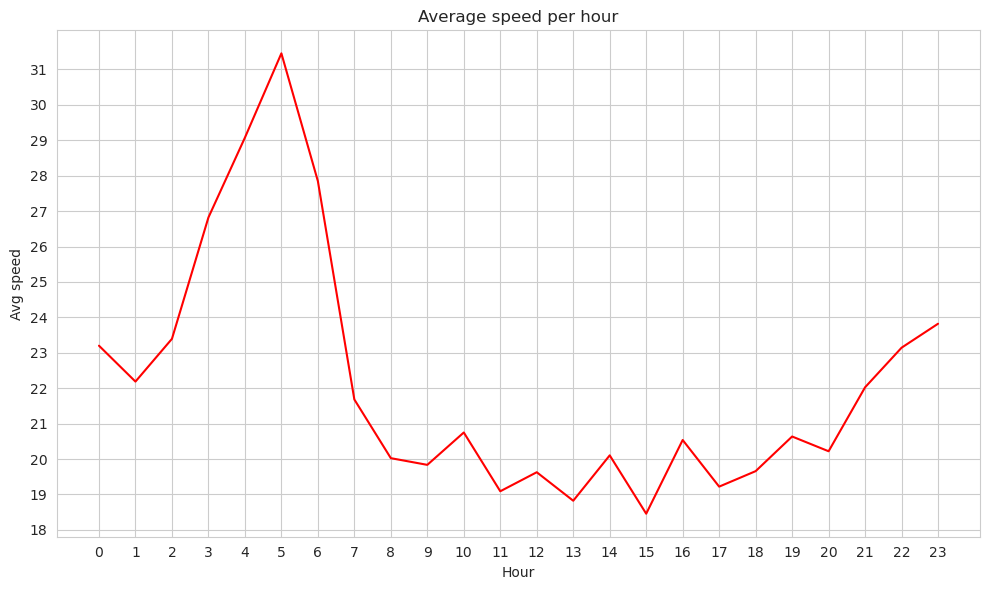

In [35]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=hours_speed_df_pd.index, y=hours_speed_df_pd.values, color='red')
plt.xlabel("Hour")
plt.ylabel("Avg speed")
plt.title("Average speed per hour")
plt.xticks(range(0,24), rotation=0) 
min = np.round(hours_speed_df_pd.values.min())
max = np.round(hours_speed_df_pd.values.max())
ysticks_ = np.unique(np.round(np.linspace(min, max, 15)))
plt.yticks(ysticks_) 
plt.tight_layout()
plt.show()

## **Study 2: Most common taxi trips**

In this study we have analyzed the most common taxi trips. We have used Spark Data Frame.  
We have followed the nesxt steps:
1. Read the file "zones.csv" that provides the borough and zone of the pickup and dropoff codes.  
2. Filter the unknown trips in the zones dataset.
3. Group by pickup and dropoff location ids counting the records and ordering by this count.
4. Join both datasets, trips and zones, in order to get the borough and zones of the pickup and dropoff location ids. 
5. Order by trip count the final result to get the most common trips.
6. Show the 10 most common trips.
7. Plot the results.

In [36]:
zones_df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(r"./Data/zones.csv")
zones_df = zones_df.filter(zones_df['LocationID'] < 264)
group_by_df = taxis_df.groupBy('PULocationID', 'DOLocationID').agg(count('*').alias('trip_count')).orderBy('trip_count', ascending=False)
PU_joined_df = group_by_df.join(zones_df, group_by_df['PULocationID'] == zones_df['LocationID'], 'inner')\
    .select('PULocationID', 'DOLocationID', 'LocationID', 'trip_count', 'Borough', 'Zone')\
    .withColumnRenamed('Borough', 'Borough_PU')\
    .withColumnRenamed('Zone', 'Zone_PU')\
    .withColumnRenamed('trip_count', 'trip_count_PU')
DO_joined_df = group_by_df.join(zones_df, group_by_df['DOLocationID'] == zones_df['LocationID'], 'inner').select('PULocationID', 'DOLocationID', 'LocationID', 'trip_count', 'Borough', 'Zone').withColumnRenamed('Borough', 'Borough_DO').withColumnRenamed('Zone', 'Zone_DO')
zones_trips_df = PU_joined_df.join(DO_joined_df, (PU_joined_df['PULocationID'] == DO_joined_df['PULocationID']) & (PU_joined_df['DOLocationID'] == DO_joined_df['DOLocationID']), 'inner').select('Borough_PU', 'Zone_PU', 'Borough_DO', 'Zone_DO', 'trip_count')
zones_trips_sorted_df = zones_trips_df.orderBy('trip_count', ascending=False)
start_time = time.time()
zones_trips_sorted_df.show(10)
end_time = time.time()
task2_spark_df_time = end_time - start_time

+----------+--------------------+----------+--------------------+----------+
|Borough_PU|             Zone_PU|Borough_DO|             Zone_DO|trip_count|
+----------+--------------------+----------+--------------------+----------+
| Manhattan|Upper East Side S...| Manhattan|Upper East Side N...|      3433|
| Manhattan|Upper East Side N...| Manhattan|Upper East Side N...|      3149|
| Manhattan|Upper East Side N...| Manhattan|Upper East Side S...|      3005|
| Manhattan|Times Sq/Theatre ...| Manhattan|West Chelsea/Huds...|      2940|
| Manhattan|        East Village| Manhattan|        East Village|      2877|
| Manhattan|Upper East Side S...| Manhattan|Upper East Side S...|      2719|
| Manhattan|Upper West Side S...| Manhattan| Lincoln Square East|      2594|
| Manhattan|Upper West Side S...| Manhattan|Upper West Side N...|      2536|
| Manhattan| Lincoln Square East| Manhattan|Upper West Side S...|      2470|
| Manhattan|Times Sq/Theatre ...| Manhattan|Penn Station/Madi...|      2202|

In [37]:
print('Time task 2 with Spark data-frames: ', task2_spark_df_time)

Time task 2 with Spark data-frames:  5.124625205993652


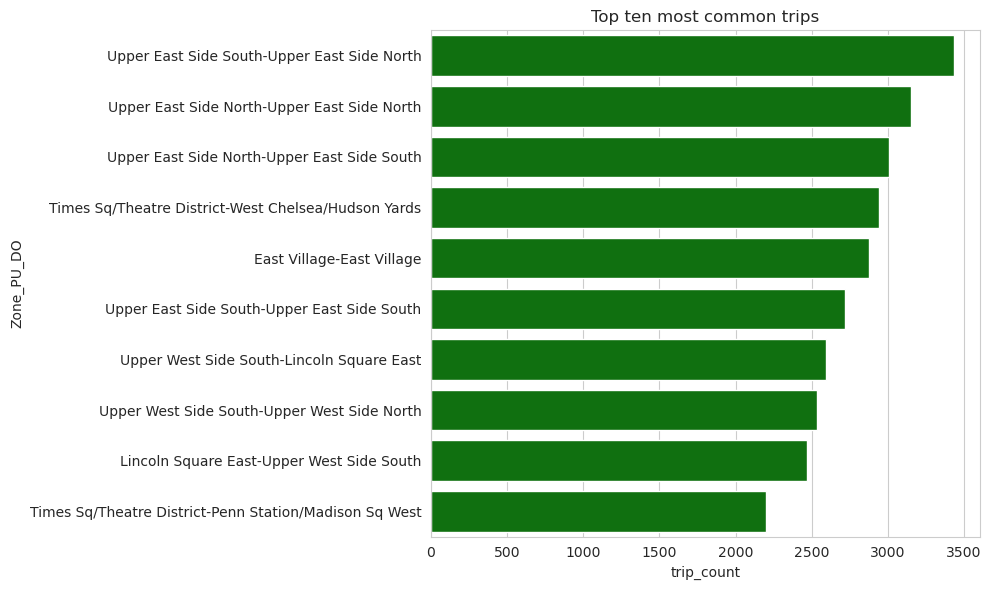

In [38]:
from pyspark.sql.functions import col
zones_trips_sorted_df = zones_trips_sorted_df.withColumn('Zone_PU_DO', concat(col('Zone_PU'), lit('-'), col('Zone_DO')))
zones_trips_sorted_df_pd = zones_trips_sorted_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(y="Zone_PU_DO", x="trip_count", data=zones_trips_sorted_df_pd.head(10), color='green')
plt.xlabel("trip_count")
plt.ylabel("Zone_PU_DO")
plt.title("Top ten most common trips")
plt.xticks(rotation=0) 
# min = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].min())
# max = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].max())
# ysticks_ = np.unique(np.round(np.linspace(min, max, 15)))
# plt.yticks(ysticks_) 
plt.tight_layout()
plt.show()

## **Study 3: Average of tips per borough**

In this study we have analyzed the average of tips per pickup borough. We have used Spark SQL.  
We have followed the nesxt steps:
1. Read the file "zones.csv" that provides the borough and zone of the pickup and dropoff codes.  
2. Join both datasets, trips and zones, in order to get the borough and average trip amount excluding the unknown zones, grouping by borough and ordering by the average trip amount . 
3. Show the results.
4. Plot the results.

In [39]:
zones_df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(r"./Data/zones.csv")

In [40]:
zones_df.createOrReplaceTempView('zones_df') 
taxis_df.createOrReplaceTempView('taxis_df') 
join_df = spark.sql("SELECT Borough, AVG(tip_amount) AS tip_amount_avg FROM taxis_df JOIN zones_df ON PULocationID = LocationID WHERE PULocationID < 264  GROUP BY Borough ORDER BY AVG(tip_amount) DESC")
start_time = time.time()
join_df.show(10)
end_time = time.time()
task3_spark_sql_time = end_time - start_time

+-------------+------------------+
|      Borough|    tip_amount_avg|
+-------------+------------------+
|     Brooklyn|1.5295506094329612|
|       Queens|1.3814509977827034|
|    Manhattan|1.3054620174908678|
|Staten Island|1.1371428571428572|
|          EWR|               0.5|
|        Bronx|0.4036954915003696|
+-------------+------------------+



In [41]:
print('Time of task 3 with Spark SQL', task3_spark_sql_time)

Time of task 3 with Spark SQL 2.7581818103790283


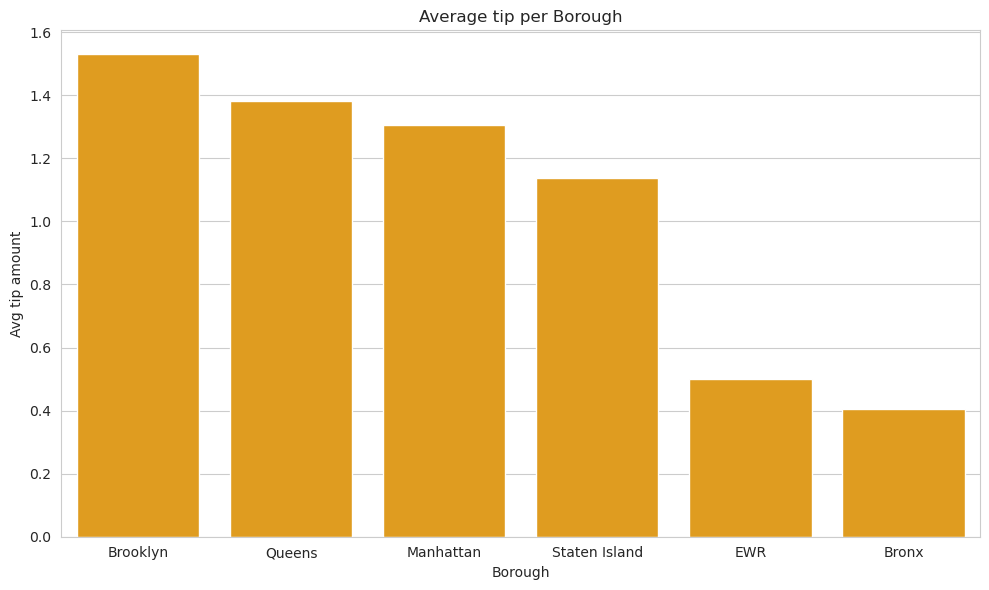

In [42]:
join_df_pd = join_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="Borough", y="tip_amount_avg", data=join_df_pd, color='orange')
plt.xlabel("Borough")
plt.ylabel("Avg tip amount")
plt.title("Average tip per Borough")
# plt.xticks(range(0,24), rotation=0) 
# min = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].min())
# max = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].max())
# ysticks_ = np.unique(np.round(np.linspace(min, max, 15)))
# plt.yticks(ysticks_) 
plt.tight_layout()
plt.show()

## **Time Analysis**

### **Spark and number of cores**

In this section we have analyzed both the different times of execution and speed-up of the different processes. 

- We have done differentes measurements using distinct number of cores: 1, 2, 4, 6, 8 and 10 (all). 

- We have created a table with all this measurements in order to analyze them and make different plots to show the results.

In [3]:
cores = np.array([1,2,4,6,8,10])
data_cleaning_spark_df_time = np.array([17.51055, 11.5567, 7.8198, 7.1175,  7.0512 , 6.4139])
task1_spark_df_time = np.array([5.902377, 3.45250, 2.49201, 2.60570,  2.2375 , 1.8649])
task1_spark_rdd_time = np.array([34.256966 , 21.998392 , 18.01433 , 17.94407 ,  16.6878   , 16.96136 ])
task1_spark_sql_time = np.array([6.7926690, 3.687486, 2.9901852, 2.642264,  2.2889 , 2.14359])
task2_spark_df_time = np.array([11.040179, 6.647932, 5.729816, 5.35511, 5.1246 , 5.066134])
task3_spark_sql_time = np.array([6.1619, 3.180148, 2.62037, 2.56909, 2.4121, 2.15730])

df_times = dict()
df_times['cores'] = cores
df_times['data_cleaning_spark_df_time'] = data_cleaning_spark_df_time
df_times['task1_spark_df_time'] = task1_spark_df_time
df_times['task1_spark_rdd_time'] = task1_spark_rdd_time
df_times['task1_spark_sql_time'] = task1_spark_sql_time
df_times['task2_spark_df_time'] = task2_spark_df_time
df_times['task3_spark_sql_time'] = task3_spark_sql_time
df_times = pd.DataFrame(df_times)

In [4]:
df_times

,cores,data_cleaning_spark_df_time,task1_spark_df_time,task1_spark_rdd_time,task1_spark_sql_time,task2_spark_df_time,task3_spark_sql_time
0,1,17.51055,5.902377,34.256966,6.792669,11.040179,6.161900
1,2,11.55670,3.452500,21.998392,3.687486,6.647932,3.180148
2,4,7.81980,2.492010,18.014330,2.990185,5.729816,2.620370
3,6,7.11750,2.605700,17.944070,2.642264,5.355110,2.569090
4,8,7.05120,2.237500,16.687800,2.288900,5.124600,2.412100
5,10,6.41390,1.864900,16.961360,2.143590,5.066134,2.157300


The following plot compares the time per cores of the first study with df, RDD or SQL.

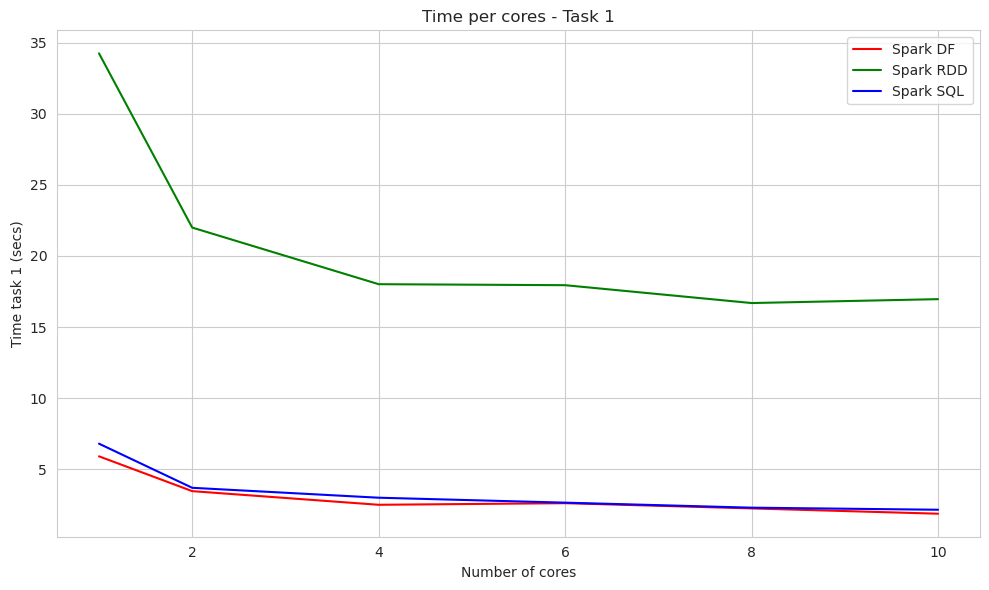

In [5]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='cores', y='task1_spark_df_time', data=df_times, color='red', label='Spark DF')
sns.lineplot(x='cores', y='task1_spark_rdd_time', data=df_times, color='green', label='Spark RDD')
sns.lineplot(x='cores', y='task1_spark_sql_time', data=df_times, color='blue', label='Spark SQL')
plt.xlabel("Number of cores")
plt.ylabel("Time task 1 (secs)")
plt.title("Time per cores - Study 1")
plt.xticks(rotation=0) 
plt.tight_layout()
plt.legend()
plt.show()

We calculate the speed up of all the processes by dividing the time of execution of one core by the time of execution with the cores used.

In [6]:
df_speed_up = pd.DataFrame(index=range(len(df_times)))

for col_name in df_times.columns:

    if col_name == 'cores':

        df_speed_up[col_name] = df_times[col_name]

    else:

        base_time = df_times.loc[df_times['cores'] == 1, col_name].iloc[0]
        df_speed_up[col_name] = base_time / df_times[col_name] 

In [7]:
df_speed_up

,cores,data_cleaning_spark_df_time,task1_spark_df_time,task1_spark_rdd_time,task1_spark_sql_time,task2_spark_df_time,task3_spark_sql_time
0,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2,1.515186,1.709595,1.557249,1.842087,1.660694,1.937614
2,4,2.239258,2.368521,1.901651,2.271655,1.926795,2.351538
3,6,2.460211,2.265179,1.909097,2.570776,2.061616,2.398476
4,8,2.483343,2.637934,2.052815,2.967657,2.154349,2.554579
5,10,2.730094,3.164983,2.019706,3.168828,2.179212,2.856302


This plot compares the speed up per cores of the first study with Spark DF, RDD and SQL.

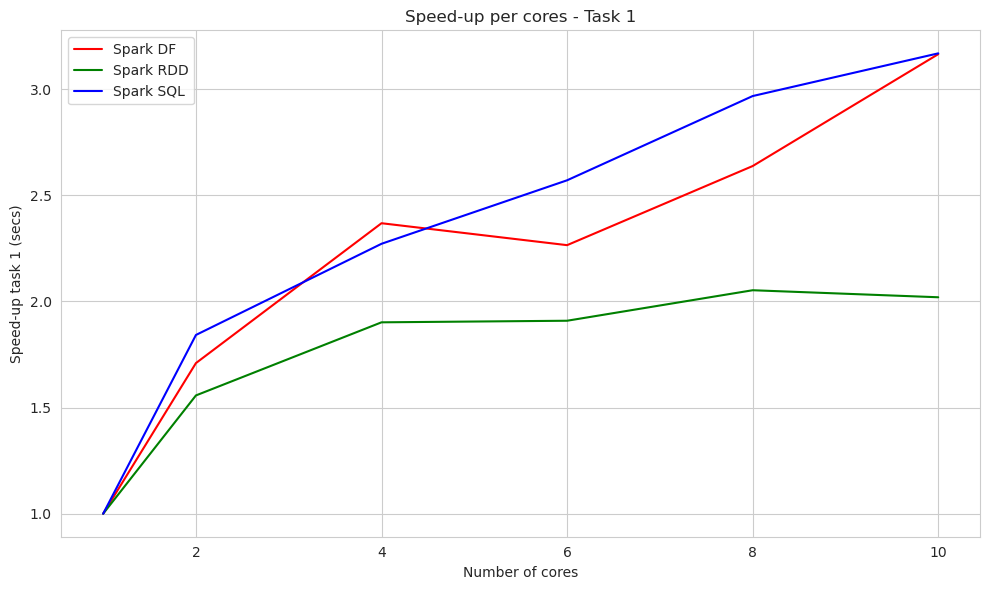

In [8]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='cores', y='task1_spark_df_time', data=df_speed_up, color='red', label='Spark DF')
sns.lineplot(x='cores', y='task1_spark_rdd_time', data=df_speed_up, color='green', label='Spark RDD')
sns.lineplot(x='cores', y='task1_spark_sql_time', data=df_speed_up, color='blue', label='Spark SQL')
plt.xlabel("Number of cores")
plt.ylabel("Speed-up task 1 (secs)")
plt.title("Speed-up per cores - Study 1")
plt.xticks(rotation=0) 
plt.tight_layout()
plt.legend()
plt.show()

The plots below show the speedup of the other studies and the clean up process per cores.

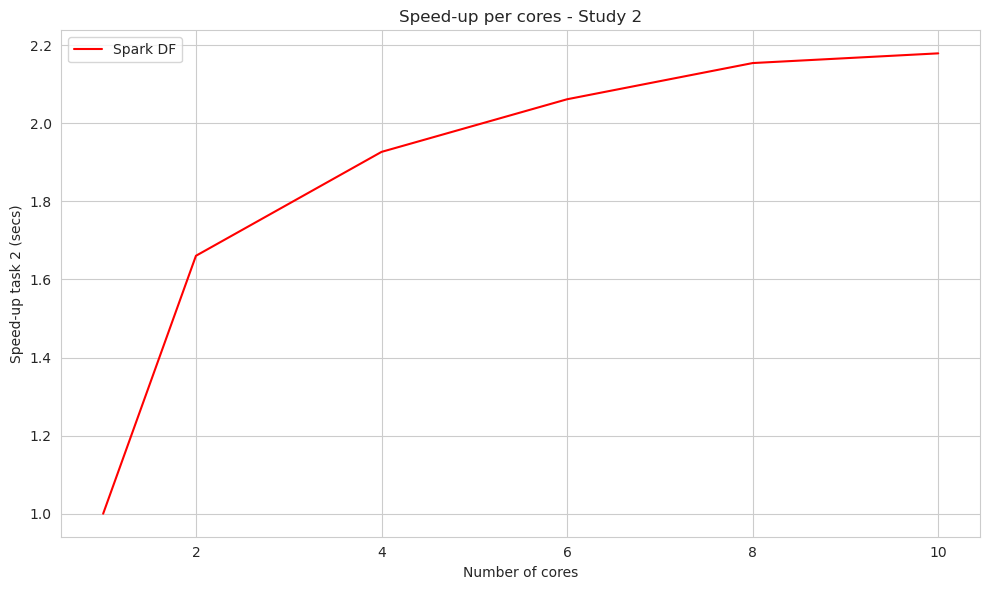

In [9]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='cores', y='task2_spark_df_time', data=df_speed_up, color='red', label='Spark DF')
plt.xlabel("Number of cores")
plt.ylabel("Speed-up task 2 (secs)")
plt.title("Speed-up per cores - Study 2")
plt.xticks(rotation=0) 
plt.tight_layout()
plt.legend()
plt.show()

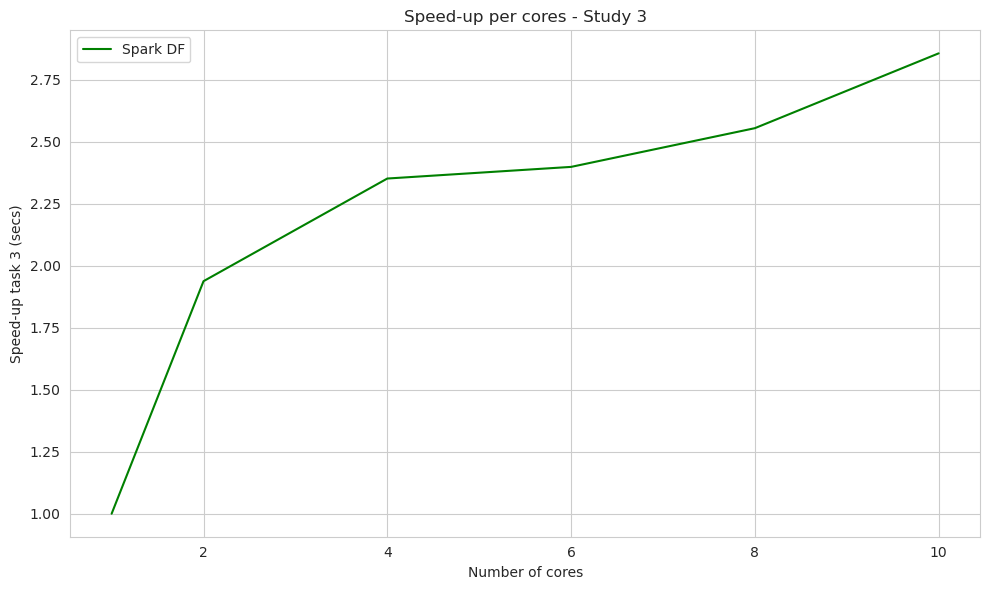

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='cores', y='task3_spark_sql_time', data=df_speed_up, color='green', label='Spark DF')
plt.xlabel("Number of cores")
plt.ylabel("Speed-up task 3 (secs)")
plt.title("Speed-up per cores - Study 3")
plt.xticks(rotation=0) 
plt.tight_layout()
plt.legend()
plt.show()

### **Spark vs Pandas vs Polars**

In [7]:
import pickle
from itertools import product

In [2]:
# Open a dictionary saved as a pickle
with open('Spark_times_df_dict.pickle', 'rb') as file:
    # Read back the pickled file
    Spark_times_df_dict = pickle.load(file)

In [3]:
# Open a dictionary saved as a pickle
with open('Pandas_times_df_dict.pickle', 'rb') as file:
    # Read back the pickled file
    Pandas_times_df_dict = pickle.load(file)

In [4]:
# Open a dictionary saved as a pickle
with open('Polars_times_df_dict.pickle', 'rb') as file:
    # Read back the pickled file
    Polars_times_df_dict = pickle.load(file)

In [5]:
for data in ['taxis.csv', 'taxis_15M.csv', 'taxis_62M.csv', 'taxis_124M.csv', 'taxis_186M.csv'] :

    if data in ['taxis.csv', 'taxis_15M.csv'] :
        Spark_times_df_dict[data].columns = ['data_reading_Spark-DF_time', 'data_cleaning_Spark-DF_time', 'task1_Spark-DF_time', 'task1_Spark-RDD_time', 'task1_Spark-SQL_time'] 
    else :
        Spark_times_df_dict[data].columns = ['data_reading_Spark-DF_time', 'data_cleaning_Spark-DF_time', 'task1_Spark-DF_time', 'task1_Spark-SQL_time'] 
          
    Pandas_times_df_dict[data].columns = ['data_reading_Pandas_time', 'data_cleaning_Pandas_time', 'task1_Pandas_time'] 
    Polars_times_df_dict[data].columns = ['data_reading_Polars_time', 'data_cleaning_Polars_time', 'task1_Polars_time'] 

In [36]:
data_names = ['taxis.csv', 'taxis_15M.csv', 'taxis_62M.csv', 'taxis_124M.csv', 'taxis_186M.csv']
methods = ['Spark-DF', 'Pandas', 'Polars', 'Spark-RDD', 'Spark-SQL']
tasks = ['data_reading', 'data_cleaning', 'task1']
def df_name(x) :
    if x in ['Spark-DF', 'Spark-RDD', 'Spark-SQL'] :
        return x[0:5]
    else :
        return x      

avg_time= dict()
for task in tasks :
    avg_time[task] = dict()

for task in tasks :
    if task in ['data_reading', 'data_cleaning']:
        for method in ['Spark-DF', 'Pandas', 'Polars'] :
            avg_time[task][method] = dict()
    else:
        for method in methods:
            avg_time[task][method] = dict()

times_df_dict = dict()
for name in ['Spark', 'Pandas', 'Polars'] :
    times_df_dict[name] = globals()[f'{name}_times_df_dict']

#########################################################################################

filtered_product = [(method, data, task) for method, data, task in product(methods, data_names, tasks) 
                    if not (method == 'Spark-RDD' and task in ['data_reading', 'data_cleaning'])
                    and not (method == 'Spark-SQL' and task in ['data_reading', 'data_cleaning'])]

for method, data, task in filtered_product :

    if method == 'Spark-RDD' and data in ['taxis_62M.csv', 'taxis_124M.csv', 'taxis_186M.csv']: 

        avg_time[task][method][data] = np.NaN

    else :
        
        avg_time[task][method][data] = times_df_dict[df_name(method)][data].describe().loc['mean', f'{task}_{method}_time']

#########################################################################################

def total_time_v1(method, data) :
    return np.sum([avg_time[task][method][data] for task in tasks])

def total_time_v2(method) :
    return {data : total_time_v1(method, data=data) for data in data_names}

avg_time['all_tasks'] = dict()

for method in ['Spark-DF', 'Pandas', 'Polars'] :

    avg_time['all_tasks'][method] = total_time_v2(method)

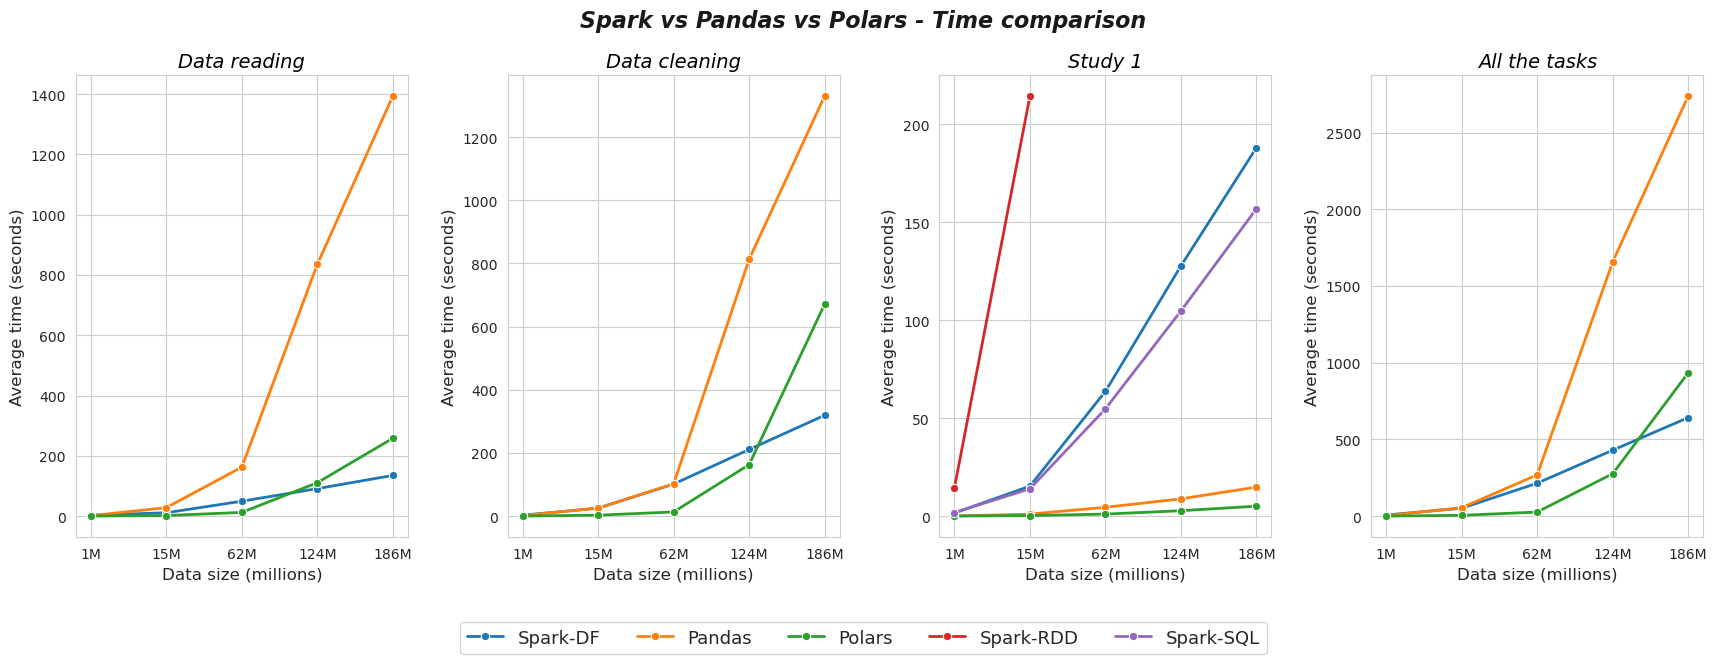

In [43]:
# Define the number of rows and columns for the matrix plot
num_cols = 4  # You can adjust the number of columns as needed
n_tasks = len(avg_time)
num_rows = int(np.ceil(n_tasks / num_cols))

data_size = ['1M', '15M', '62M', '124M', '186M']
titles = ['Data reading', 'Data cleaning', 'Study 1', 'All the tasks']

# Create a subplot with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(21, 6))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

n_methods = 5 # (spark-df, spark-sql, spark-rdd pandas, polars)
colors = sns.color_palette("tab10", n_methods)

# Loop through each 'geo' and create a subplot in the matrix
for (i, task), title in zip(enumerate(avg_time.keys()), titles) :

    ax = axes[i]  # Get the current axis
    for method, color in zip(avg_time[task].keys(), colors) :
        sns.lineplot(x=data_size, y=avg_time[task][method].values(), color=color, marker='o', markersize=6, linestyle='-', linewidth=2, label=method, ax=ax)    
    ax.set_xlabel("Data size (millions)", fontsize=12)
    ax.set_ylabel("Average time (seconds)", fontsize=12)
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='y', rotation=0)
    ax.set_title(title, fontsize=14, weight='normal', style='italic', color='black')
    ax.get_legend().remove()  # Remove individual subplot legends
    if i == 2 : # Getting the labels of the third plot (the one with more labels), for build a general legend.
        handles, labels = ax.get_legend_handles_labels() 

# Remove any unused subplots in case the number of 'geo' values is less than num_rows * num_cols
for j in range(len(avg_time), num_rows * num_cols):
    fig.delaxes(axes[j])

# Add a shared legend outside of the subplots
fig.legend(handles, methods, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=n_methods, fontsize=13)

plt.suptitle('Spark vs Pandas vs Polars - Time comparison', fontsize=16, y=0.99, weight='bold', style='italic', color='black', alpha=0.9) # Establishing a general tittle for the plot.
plt.subplots_adjust(hspace=1, wspace=0.3) # Adjust vertical (hspace) and horizontal (wspace) spacing
# fig.savefig('Spark_Pandas_Polars' + '.jpg', format='jpg', dpi=600, bbox_inches="tight")
# plt.tight_layout()
plt.show()